In [5]:
import json
import matplotlib.pyplot as plt

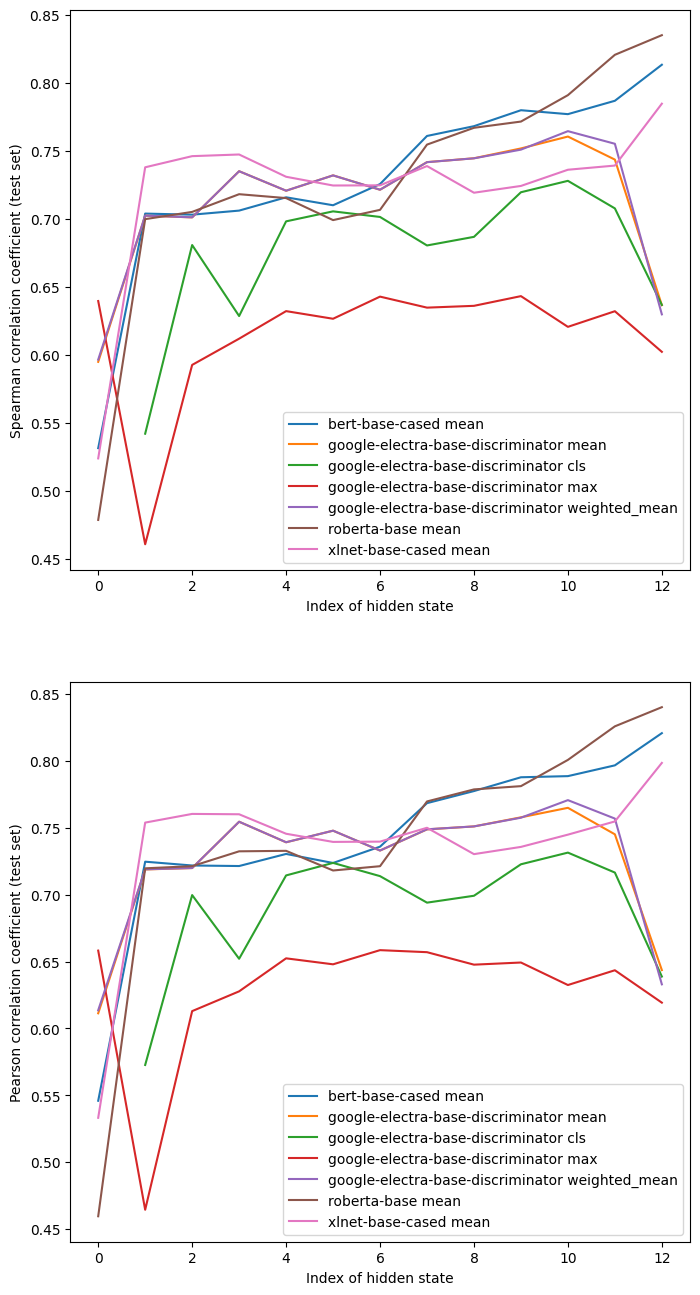

In [15]:
models = [
    ("bert-base-cased", ["mean"], 13), 
    ("google-electra-base-discriminator", ["mean", "cls", "max", "weighted_mean"], 13),
    ("roberta-base", ["mean"], 13),
    #("google-electra-base-generator", ["mean", "cls", "max", "weighted_mean", "mean_encoder"], 13),
    ("xlnet-base-cased", ["mean"], 13),
    #("google-electra-small-discriminator", ["mean", "cls", "max", "weighted_mean"], 13),
    #("google-electra-small-generator", ["mean", "cls", "max", "weighted_mean"], 13),
    #("google-electra-large-generator", ["mean"], 24)
]

fig, axs = plt.subplots(2, 1, figsize=(8, 16))

for x in models:
    m = x[0]
    pool = x[1]
    c = x[2]
    for p in pool:
        spearman, pearson = [], []
        std_spearman, std_pearson = [], []
        for i in range(c):
            res = json.load(open(f"../output/{m}_{p}_{i}_to_{i+1}/test_results.json"))
            if res["stdev_cosine_spearman_test"] == float("nan"):
                print(m, p, c,res["stdev_cosine_spearman_test"] )
            spearman.append(res["mean_cosine_spearman_test"])
            pearson.append(res["mean_cosine_pearson_test"])

        axs[0].plot(spearman, label=f"{m} {p}")
        axs[0].set_xlabel("Index of hidden state")
        axs[0].set_ylabel("Spearman correlation coefficient (test set)")
        axs[0].legend()
        
        axs[1].plot(pearson, label=f"{m} {p}")
        axs[1].set_xlabel("Index of hidden state")
        axs[1].set_ylabel("Pearson correlation coefficient (test set)")
        axs[1].legend()

In [ ]:
models = [
    ("bert-base-cased", ["mean"], 13), 
    #("google-electra-base-discriminator", ["mean", "cls", "max", "weighted_mean"], 13),
    #("google-electra-base-generator", ["mean", "cls", "max", "weighted_mean"], 13),
    #("roberta-base", ["mean"], 13),
    ("google-electra-small-discriminator", ["mean", "cls", "max", "weighted_mean"], 13),
    ("google-electra-small-generator", ["mean", "cls", "max", "weighted_mean"], 13),
    #("google-electra-large-generator", ["mean"], 24)
]

fig, axs = plt.subplots(2, 1, figsize=(8, 16))

for x in models:
    m = x[0]
    pool = x[1]
    c = x[2]
    for p in pool:
        spearman, pearson = [], []
        for i in range(c):
            res = json.load(open(f"../output/{m}_{p}_{i}_to_{i+1}/test_results.json"))
            spearman.append(res["mean_cosine_spearman_test"])
            pearson.append(res["mean_cosine_pearson_test"])

        axs[0].plot(spearman, label=f"{m} {p}")
        axs[0].set_xlabel("Index of hidden state")
        axs[0].set_ylabel("Spearman correlation coefficient (test set)")
        axs[0].legend()
        
        axs[1].plot(pearson, label=f"{m} {p}")
        axs[1].set_xlabel("Index of hidden state")
        axs[1].set_ylabel("Pearson correlation coefficient (test set)")
        axs[1].legend()

In [ ]:
models = [
    ("bert-base-cased", ["mean", "cls", "max"], 13), 
    ("google-electra-base-discriminator", ["mean", "cls", "max"], 13),
    ("google-electra-base-generator", ["mean", "cls", "max"], 13),
]

fig, axs = plt.subplots(2, 1, figsize=(8, 16))

for x in models:
    m = x[0]
    pool = x[1]
    c = x[2]
    for p in pool:
        spearman, pearson = [], []
        for i in range(c):
            res = json.load(open(f"../output/{m}_{p}_{i}_to_{i+1}/test_results_unsupervised.json"))
            spearman.append(res["mean_cosine_spearman_test"])
            pearson.append(res["mean_cosine_pearson_test"])

        axs[0].plot(spearman, label=f"{m} {p}")
        axs[0].set_xlabel("Index of hidden state")
        axs[0].set_ylabel("Spearman correlation coefficient (test set)")
        axs[0].legend()
        
        axs[1].plot(pearson, label=f"{m} {p}")
        axs[1].set_xlabel("Index of hidden state")
        axs[1].set_ylabel("Pearson correlation coefficient (test set)")
        axs[1].legend()